# 0.0 Imports

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from sklearn import ensemble as en
from sklearn import cluster as c
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc 
#from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap
from pandas_profiling import ProfileReport

from plotly import express as px

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

## 0.1 Helper Function

In [46]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

# def hyperparameter_tunning(model, clusters,data):
#     # wss
#     wss = kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
#                          timings=False )
#     wss.fit(data)
#     # ss 
#     ss = KElbowVisualizer(c.KMeans(),
#                          k=clusters,
#                          metric='silhouette',
#                          timings=False)
#     ss.fit(data)
#     df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
#                        'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
#     return df
   

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [47]:
df = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [48]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente reside

In [49]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [50]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [51]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [52]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [53]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

In [54]:
# Separate dataframe with NAs
df_missing = df1.loc[df1.customer_id.isna()]
df_full = df1.loc[~df1.customer_id.isna()]

In [55]:
# Checking if any invoice_no in df_missing is present in df_full so we could add the respective customer_id
print(df_full.invoice_no.isin(df_missing.invoice_no.drop_duplicates()).sum())

0


In [56]:
# Check the number of unique invoices
df_missing.invoice_no.nunique()

3710

In [57]:
# create customer_ids in a reference dataframe
df_invoice = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_invoice['customer_id'] = np.arange(19000,19000+len(df_invoice),1)

# merge original dataframe with reference dataframe
df1 = pd.merge(df1,df_invoice, on='invoice_no',how='left')

# coalesce - fill the customer_id column with the column that doen not have NA.
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x','customer_id_y'], axis=1,inplace=True)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


## 1.6 Change data types

In [58]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [59]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7 Descriptive Statistics

In [60]:
num = df1.select_dtypes(include=['int64','float64'])
cat = df1.select_dtypes(exclude=['int64','float64'])

### 1.7.1 Numerical Variables

In [61]:
# Central Tendency - Mean, Median

ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - Min, Max, Standard Deviation, Range, Skew, Kurtosis

d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(np.min)).T
d3 = pd.DataFrame(num.apply(np.max)).T
d4 = pd.DataFrame(num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatanate
num_df = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
num_df.columns =['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_df

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,9.552250,3.00,218.080957,-80995.00,80995.0,161990.00,-0.264076,119769.160031
1,unit_price,4.611114,2.08,96.759764,-11062.06,38970.0,50032.06,186.506972,59005.719097


### Notes

1. `quantity` negativo pode ser devolução
2. `unit_price` negativo.

### 1.7.2 Categorical variables

Invoice Nº

In [62]:
# Identifying all invoice numbers that represent chargebacks
df_chargeback = df1.loc[df1.invoice_no.apply(lambda x: bool(re.search('[^0-9]+',x))),:]

print('Total number of chargebacks:',df_chargeback.shape[0])
print('Percetage of chargebacks:', round((df_chargeback.shape[0]/df1.shape[0]),3))
print('Total number or negative quantity: {}'.format(len(df_chargeback[df_chargeback.quantity<0])))

Total number of chargebacks: 9291
Percetage of chargebacks: 0.017
Total number or negative quantity: 9288


Stock Code

In [63]:
# Identifying stock codes that contain only characters

df1.loc[df1.stock_code.apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To Do**: remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']

Description

In [64]:
df1.description.head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

**To Do**: remove `description`

Country

In [65]:
df1.country.value_counts(normalize=True).head().round(2)

United Kingdom    0.91
Germany           0.02
France            0.02
EIRE              0.02
Spain             0.00
Name: country, dtype: float64

In [66]:
# Top 10 countries with the most purchases
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


**To Do**: Keep only country names (Remove 'European Community', 'Unspecified')

# 2.0 Feature Filtering

In [67]:
df2 = df1.copy()

## 2.1 Numerical features

In [68]:
# Unit price - Select product with at least 0.04 unit price 
df2 = df2.loc[df2['unit_price']>=0.04]

# Quantity - Remove customers with zero quantity in total
total_quantity = df2[['quantity','customer_id']].groupby('customer_id').sum()
customers_zero_quantity = total_quantity[total_quantity.quantity==0].index.to_list()

df2 = df2.loc[~df2['customer_id'].isin(customers_zero_quantity)]

## 2.2 Categorical features

In [69]:
# Stock Code - remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 =df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description - remove description
df2.drop('description', axis=1, inplace=True)

# Country - Keep only country names: (Remove 'European Community', 'Unspecified')
df2 =df2[~df2.country.isin(['European Community', 'Unspecified'])]

# Bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]



## 2.3 Separate dataset

In [70]:
# Quantity - CREATE TWO SEPARATE DATAFRAMES
# One for the purchases and another for the returns

df_chargeback = df2.loc[df2['quantity']<0,:]
df_purchases= df2.loc[df2['quantity']>0,:]

# 3.0 Feature Engeneering

In [71]:
df3 = df2.copy()

## 3.1 Feature Creation

The main ideia here is to reduce the data granularity into rows that represent each one a different customer.

In [72]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

### 3.1.1 Gross Revenue

In [73]:
# Gross Revenue per item purchased
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Gross Revenue per customer
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency (Days since the last purchase)

In [74]:
# Recency - Last Day purchase
df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3  Number of purchases

In [75]:
df_number_purch = df_purchases[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref,df_number_purch, on='customer_id', how='left' )

df_ref.rename(columns={'invoice_no':'number_of_purchases'}, inplace=True)
# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
dtype: int64

### 3.1.4 Quantity of products purchased

In [76]:
df_bs =df_purchases[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_bs.rename(columns={'quantity':'total_quantity'}, inplace=True)
df_ref = pd.merge(df_ref, df_bs, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
dtype: int64

### 3.1.5 Product variety (Unique products purchased)

In [77]:
df_var = df_purchases[['customer_id','stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_var, on='customer_id',how='left')
df_ref.rename(columns={'stock_code':'product_variety'}, inplace=True)

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
product_variety        91
dtype: int64

### 3.1.6 Average Ticket

In [78]:
df_avg_ticket = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
product_variety        91
avg_ticket             91
dtype: int64

### 3.1.7 Average Recency Days 

In [79]:
# Create columns to make the calculation
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'],ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] =df_aux['invoice_date'].shift() #next invoice date

# Calculate recency between invoices
df_aux['avg_recency_days'] = df_aux.apply(lambda x:(x['invoice_date']-x['previous_date']).days if x['customer_id']== x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'],axis=1).dropna()

# Calculate average recency in days
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref,df_avg_recency_days,on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
dtype: int64

### 3.1.8 Devoluções

In [80]:
df_return = df_chargeback[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_return.rename(columns={'quantity':'returns'}, inplace=True) # rename column
df_ref = pd.merge(df_ref,df_return, on='customer_id', how='left')
df_ref['returns'] = df_ref['returns'] * -1
df_ref['returns'].fillna(value=0, inplace=True) # Fill NAs with O (clients with no chargebacks)

df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
dtype: int64

### 3.1.9 Frequency

In [81]:
df_aux = ( df2[['customer_id', 'invoice_no','invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date','max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days)+1 ),
                                                                purchases = ('invoice_no','count') )).reset_index()  
# Frequency

df_aux['frequency'] = df_aux[['purchases','days_']].apply(lambda x: x['purchases']/x['days_'] if x['days_'] != 0 else 0, axis=1)
 
# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
dtype: int64

### 3.1.10 Average Basket Size (Média de produtos comprados por compra)

In [82]:
df_aux = ( df_purchases[['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchases=('invoice_no','nunique'),
                                                                                         n_products=('quantity','sum')).
                                                                                        reset_index())

# Calculate Average Basket Size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
avg_basket_size          91
dtype: int64

### 3.1.11 Unique Basket Size (Média de produtos únicos comprados por compra)

In [83]:
df_aux = ( df_purchases[['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchases=('invoice_no','nunique'),
                                                                                         unq_products=('stock_code','count')).
                                                                                        reset_index())

# Calculate Average Basket Size
df_aux['unq_basket_size'] = df_aux['unq_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','unq_basket_size']], on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
avg_basket_size          91
unq_basket_size          91
dtype: int64

# 4.0 Exploratory Data Analysis

In [84]:
# Drop NAs
df_ref.dropna(inplace=True)

df4 = df_ref.copy()

In [85]:
# # Using Pandas Profile
# profile = ProfileReport(df4, title='Insiders Clustering - Exploratory Data Analysis', html={'style':{'full_width':True}})
# profile.to_file(output_file="EDA1.html")

## 4.1 Univariate Analysis

Notes from Pandas Profilling analysis:

* Possibility of outlier in `gross_revenue` (big difference between 95-th percentile and Maximum)
* Half of the customer base has done a purchase in the last month (`recency_days` median = 31 days)
* 75% of the customers have done only up to 6 purchases.
* Possibility of outlier: Interesting `total_quantity` mean (~ 1613)
* 95% of the customers have up to 90 dollars in `avg_ticket`
* Almost half of the customers has done a `return` (49,9%)
* Half of the customers has bought, in average,up to 172 products per purchase (`avg_basket_size`).

## 4.2 Bivariate Analysis

Features Notes:
* `avg_ticket` and `frequency` do not present a significant variance
* `recency_days` and `avg_recency_days` carry the same information content.
* `avg_basket_size` is more important than `unq_basket_size` in terms of relevent information to the problem.

<Figure size 1800x864 with 0 Axes>

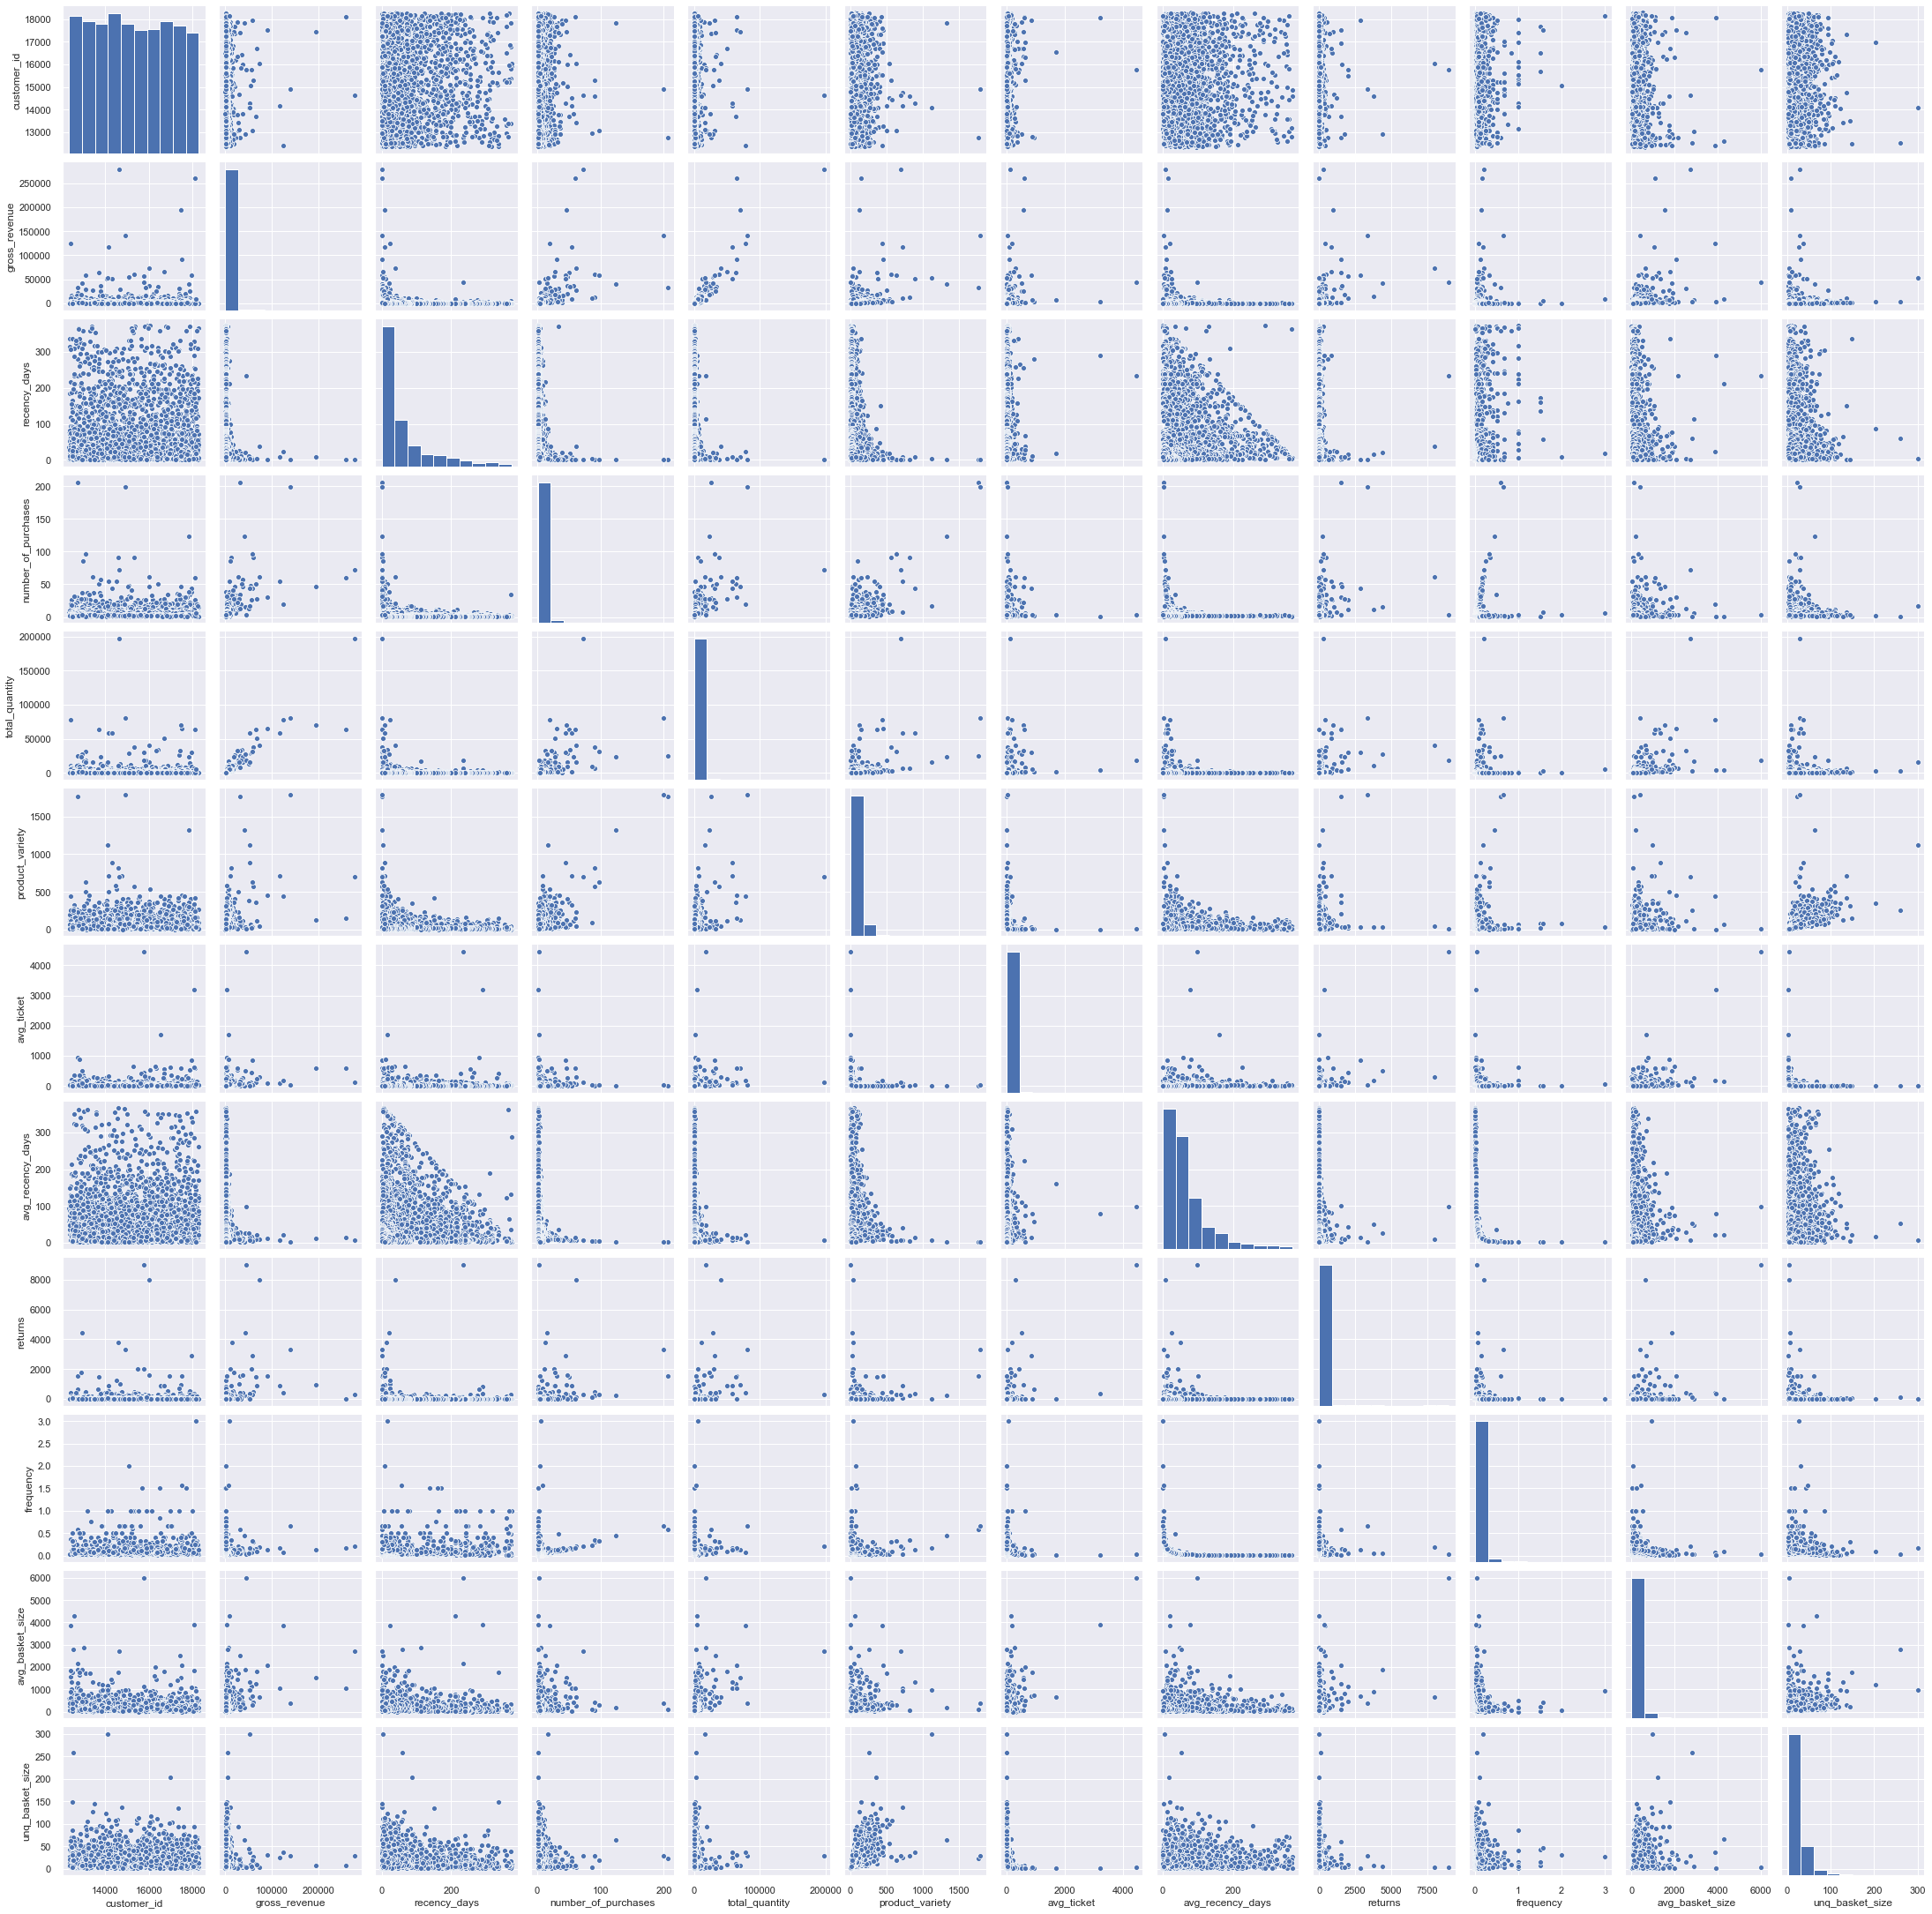

In [86]:
plt.figure(figsize(25,12));
# sns.pairplot( df4[['gross_revenue','recency_days', 'number_of_purchases','total_quantity', 'product_variety',
#                   'returns','avg_basket_size']]);

sns.pairplot( df4);

## 4.3 Data Space Study

In [87]:
df_space = df4.copy()

# Cols selected after data variation analysis
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'product_variety', 'frequency', 'returns']

df_space = df_space[cols_selected]

In [88]:
# MinMaxScaler definition
mms = pp.MinMaxScaler()

# Standardization 

df_space['gross_revenue'] = mms.fit_transform( df_space[['gross_revenue']])
df_space['recency_days'] = mms.fit_transform( df_space[['recency_days']])
df_space['product_variety'] = mms.fit_transform( df_space[['product_variety']])
df_space['returns'] = mms.fit_transform( df_space[['returns']])
df_space['frequency'] = mms.fit_transform( df_space[['frequency']])

X_space = df_space.drop('customer_id',axis=1)

# Check X space shape
X_space.shape

### 4.3.1 PCA

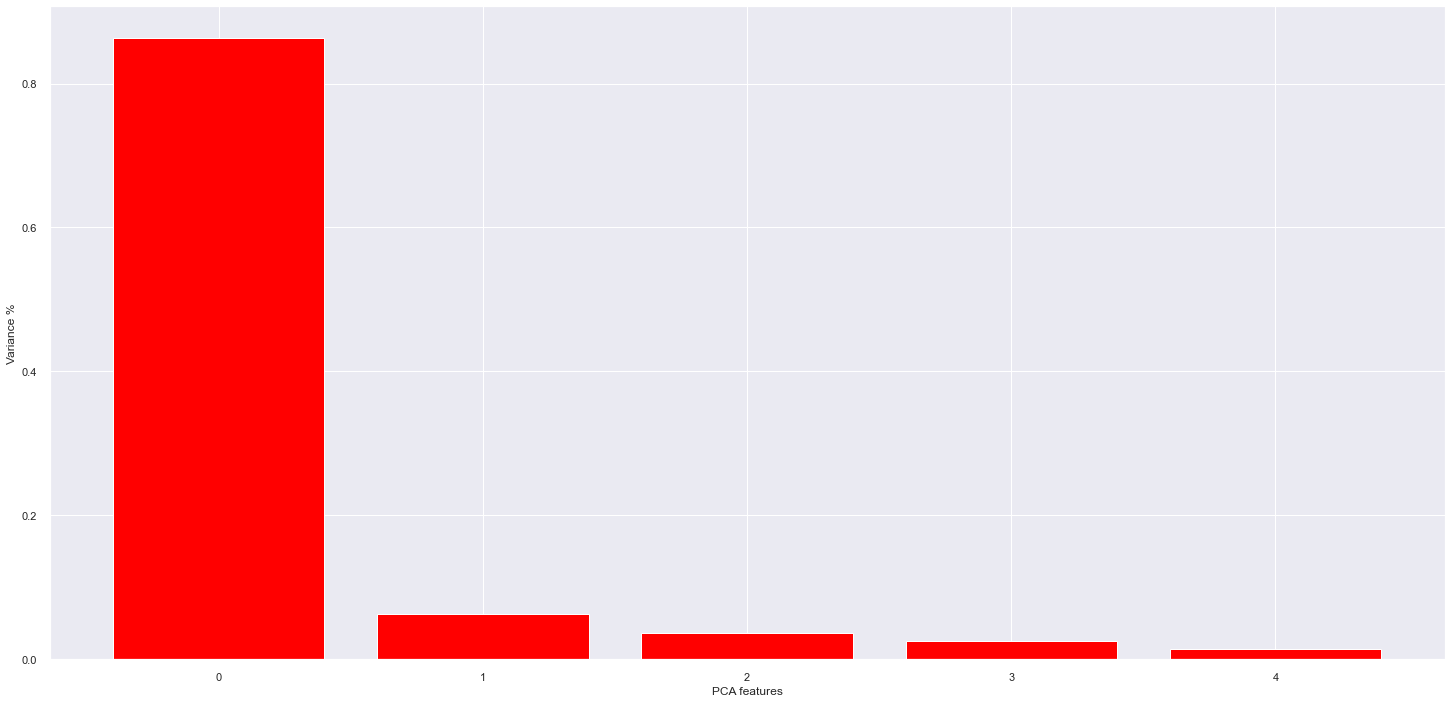

In [45]:
# Create PCA
pca = PCA(n_components = X_space.shape[1], random_state=42)
principal_components = pca.fit_transform(X_space)
                                        
# Plot the explained variance
features  = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)

# SAve components to a Dataframe
df_pca = pd.DataFrame(principal_components)

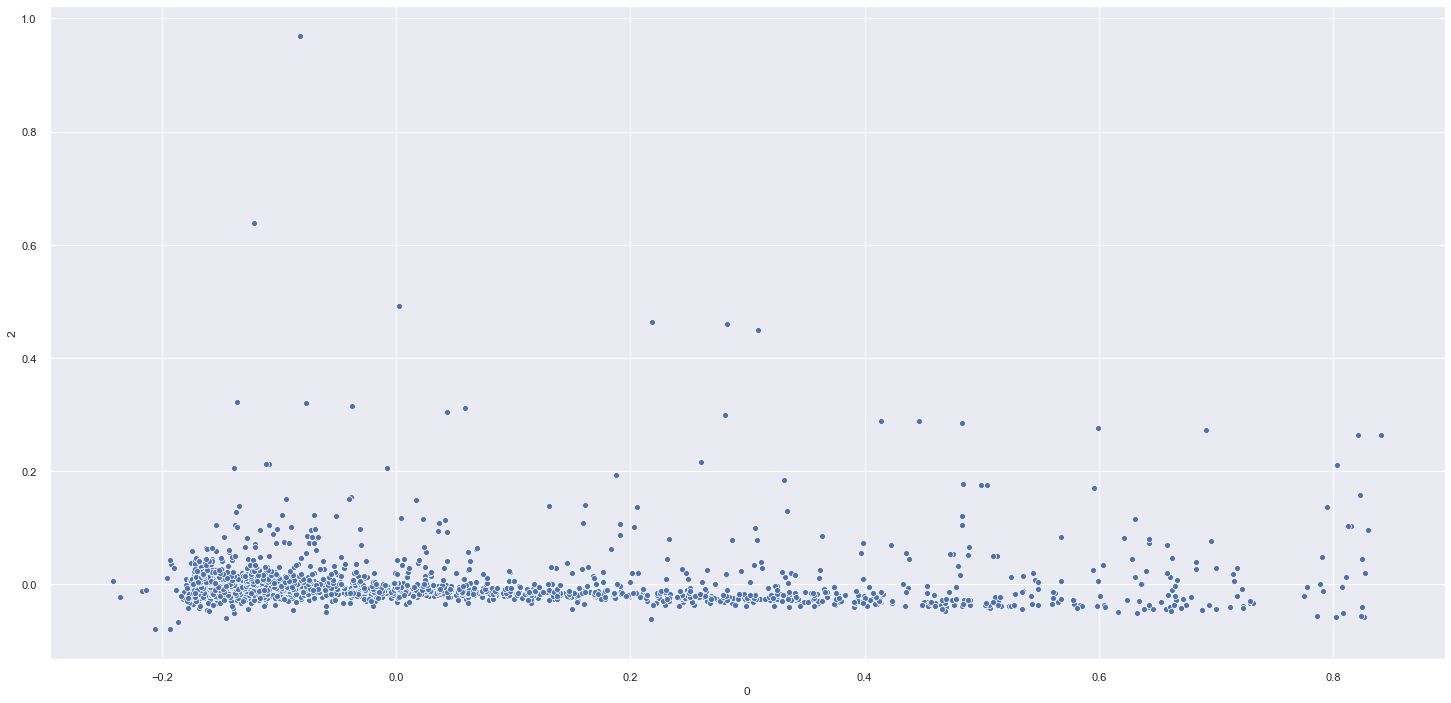

In [46]:
sns.scatterplot(x=0,y=2,data=df_pca);

### 4.3.2 UMAP

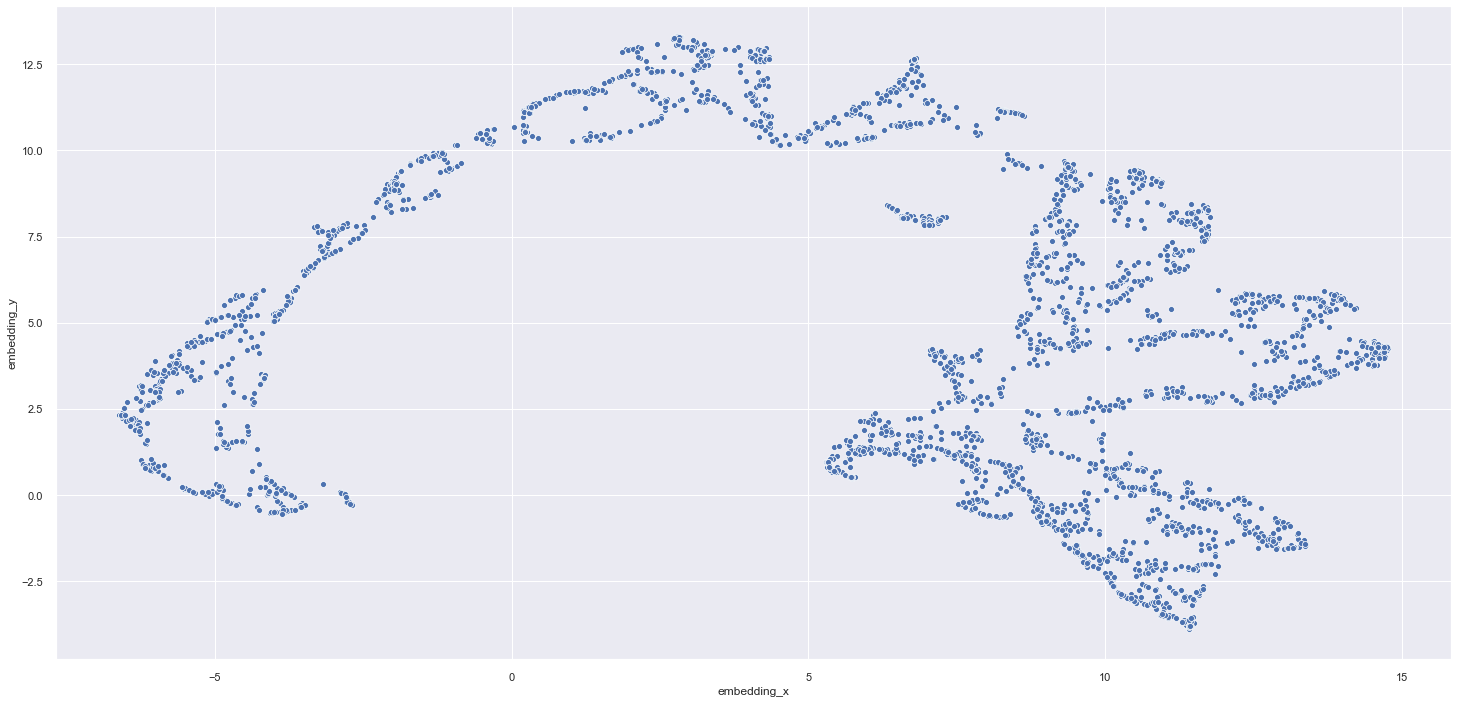

In [47]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_space)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x ='embedding_x',
                y = 'embedding_y',
               data=df_umap);

###  4.3.3. t-SNE

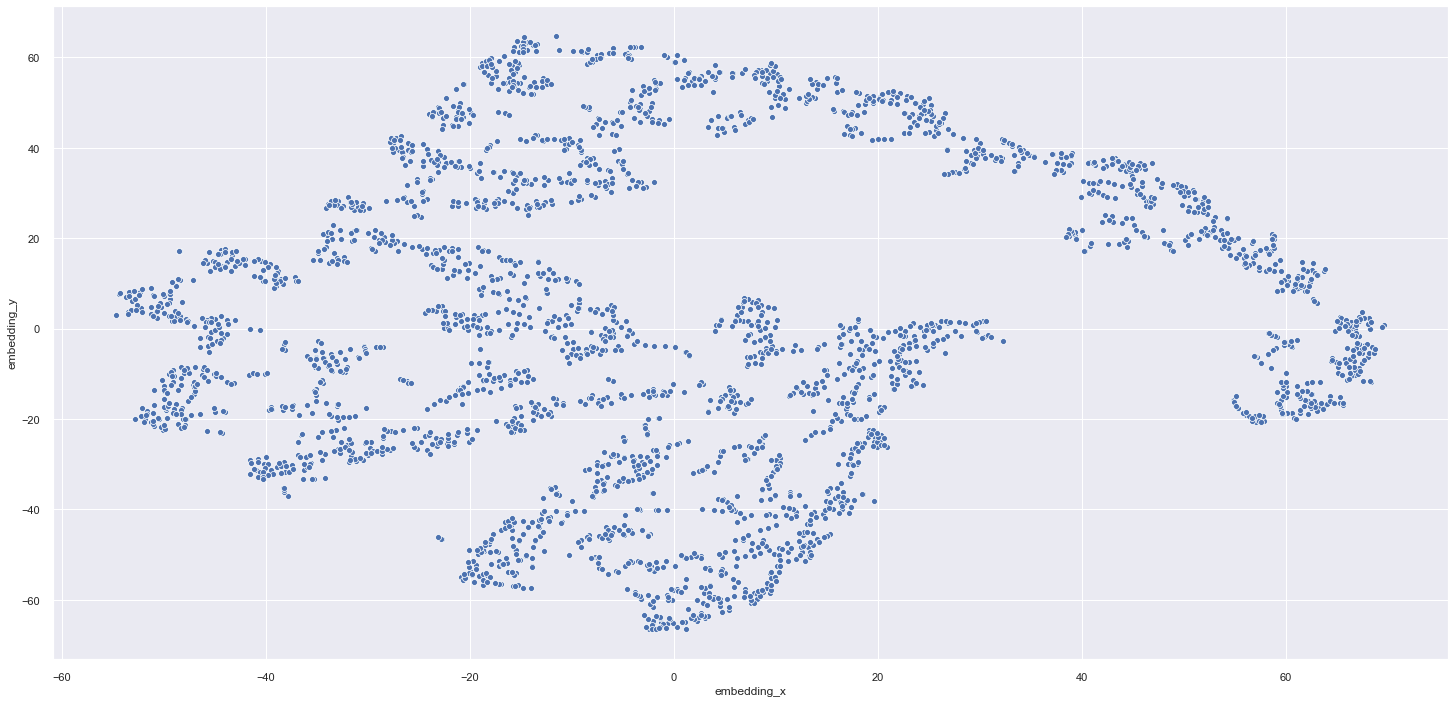

In [48]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X_space)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne );

### 4.3.4 Tree-Based Embedding

**Note**: the dataframe below shows a unique customer per row, a unique tree per column. The values inside each cell represents the position (leaf number) of the respective customer in that tree.

In [49]:
# training dataset
X = df4[cols_selected].drop(columns=['customer_id','gross_revenue'],axis=1)
y =df4['gross_revenue']

# model definition
rf = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf.fit(X,y)

# Turn leafs into dataframe
df_leaf = pd.DataFrame(rf.apply(X))# Apply trees in the forest to X, return leaf indices
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3412,1743,3636,1991,1074,1978,1752,3562,2613,1882,1615,1720,1893,1593,3548,1552,1554,3596,1693,1540,1810,3461,1955,3609,1791,1662,1761,3460,1351,2010,1751,3603,3616,3516,3580,2069,1782,1871,2994,1748,3508,3554,3711,1792,1962,3462,1867,1278,3044,1352,1943,1954,3521,3219,3166,3658,1766,2775,1873,1651,1793,3171,3412,3682,1823,1678,2236,1884,3612,1851,3694,3582,3476,1732,1493,2803,1837,3621,2357,1600,3472,3615,1704,3485,3614,1712,3615,1788,2105,3521,3676,2975,3490,2943,2360,1411,1788,1556,3552,1715
1,3592,2994,3106,3136,3129,3621,3050,3684,3714,3188,3356,3260,3624,3126,3111,3025,2925,3104,3026,2641,2663,3654,3347,3581,3146,3538,3050,3634,2967,3649,3241,3228,3674,3584,3648,3643,3038,3070,3135,3046,3603,3063,3272,3092,3283,3588,3185,3595,3226,3344,3089,3705,2951,3010,3233,3646,3006,3627,3095,3013,3063,3308,3648,3735,3037,3007,3194,3633,3600,3103,3128,3670,3190,3263,3174,2883,3235,3066,2831,2982,3180,3619,3050,3586,3636,3103,3687,3344,3425,3596,3636,3104,3086,3189,3276,3161,3238,3148,3626,3256
2,3539,2941,3424,3115,3046,3594,2878,3428,3588,3215,3363,3275,3443,2657,3396,3125,2571,3433,3414,3427,3474,3128,3300,3380,2671,3530,2649,3319,3021,3617,3205,3631,3397,3351,3398,3581,3055,3075,3073,3031,3225,3399,3500,3048,3227,3267,3275,3632,2827,3347,3255,3590,3364,3060,2967,3395,3179,3688,3042,3038,3016,2960,3556,3463,2950,2889,461,3588,3352,3580,3548,3409,3573,3239,2637,3520,3096,3386,3655,3560,3394,3378,3009,3340,3428,3195,3377,3365,3598,3347,3537,2788,3426,2688,3334,3307,2685,3102,3365,3343
3,589,684,687,931,294,940,861,978,415,946,632,482,1231,770,1173,542,904,719,678,472,866,680,1094,556,734,1083,1308,703,1068,717,314,842,1160,938,478,1081,1434,529,1218,839,1052,1378,579,1338,891,854,791,1402,608,423,672,1584,671,519,576,1374,375,911,716,758,900,642,400,774,968,674,1513,1040,1010,1218,860,1319,731,1041,515,889,1105,978,1071,820,1570,566,946,693,727,1005,760,832,912,789,773,331,1264,895,576,862,701,1156,1246,755
4,1445,1697,1597,1985,1028,1972,1744,1521,1589,1499,1607,1707,1838,1370,1623,1260,1453,1694,1567,1492,1458,3418,1615,1137,1443,1440,1709,1608,1334,1993,1404,1233,950,1634,1407,1661,1755,1864,2970,1472,3405,1884,1245,549,1853,3357,1728,1044,3012,1186,1811,1099,1338,1356,3064,1002,1576,1631,1831,1521,1526,3108,1136,1351,1816,1675,2195,1785,1402,1841,1783,1096,1670,1699,1383,2689,1600,1635,2129,1590,882,1679,1476,1695,1687,1666,1244,1778,2095,1658,1407,2930,1617,2793,2314,1291,1687,1447,1874,1618


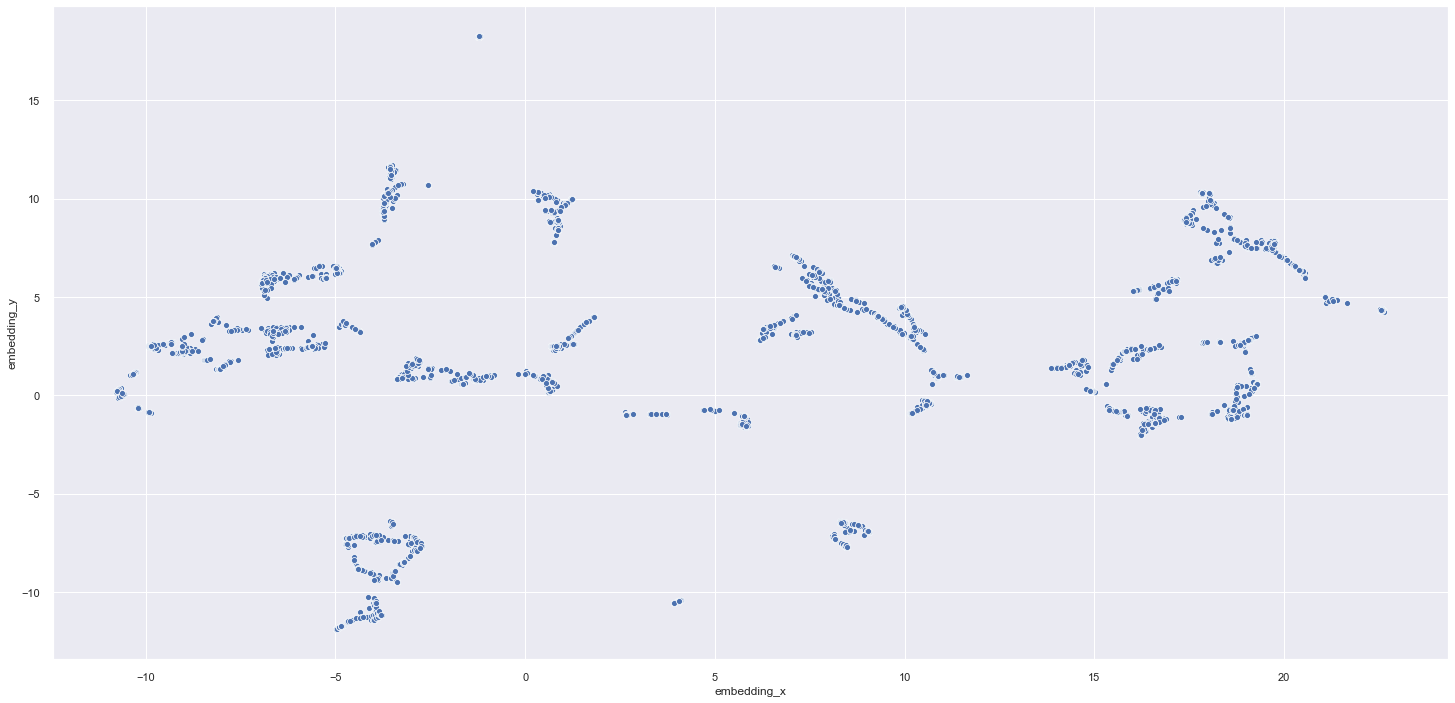

In [50]:
# Reduce dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree );

# 5.0 Data Preparation

In [51]:
# df5 = df4.copy()
df5 = df_tree.copy()

Min Max Scaler

In [52]:
# ss = pp.MinMaxScaler()

# df5.gross_revenue = ss.fit_transform(df5[['gross_revenue']])
# df5.recency_days = ss.fit_transform(df5[['recency_days']])
# df5.number_of_purchases = ss.fit_transform(df5[['number_of_purchases']])
# df5.total_quantity = ss.fit_transform(df5[['total_quantity']])
# df5.avg_basket_size = ss.fit_transform(df5[['avg_basket_size']])
# df5.product_variety = ss.fit_transform(df5[['product_variety']])
# df5.avg_ticket = ss.fit_transform(df5[['avg_ticket']])
# df5.avg_recency_days = ss.fit_transform(df5[['avg_recency_days']])
# df5.returns = ss.fit_transform(df5[['returns']])
# df5.frequency = ss.fit_transform(df5[['frequency']])
# df5.avg_basket_size = ss.fit_transform(df5[['avg_basket_size']])
# df5.unq_basket_size = ss.fit_transform(df5[['unq_basket_size']])

In [53]:
# Check data preparation
df5.head()

,embedding_x,embedding_y
0,1.585890,3.689599
1,18.979393,2.241164
2,17.846424,2.677089
3,-7.455251,3.336750
4,0.681388,2.507767


# 6.0 Feature Selection

As we are to create clusters' profile that are made of the average of each variable, it does not make much sense to already use averaged variables, such as `avg_basket_size`, `avg_ticket`, `avg_recency_days` and `unq_basket_size`. Moreover, we can discard variables that carry similar information content like `number_of_purchases`, `total_quantity` and `product_variety`. From these last three, we chose `product_variety`.

In [54]:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'product_variety', 'frequency', 'returns']

In [55]:
# df6 = df5[cols_selected]
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [56]:
# X = df6.drop('customer_id',axis=1)
X = df_tree.copy()

# Listing possible values for k
# clusters =[2,3,4,5,6,7]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1 KMeans

In [57]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # Model training
    kmeans_model.fit(X)

    # Model Prediction
    labels = kmeans_model.predict(X)

    # Model performance
    sil_score = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil_score)

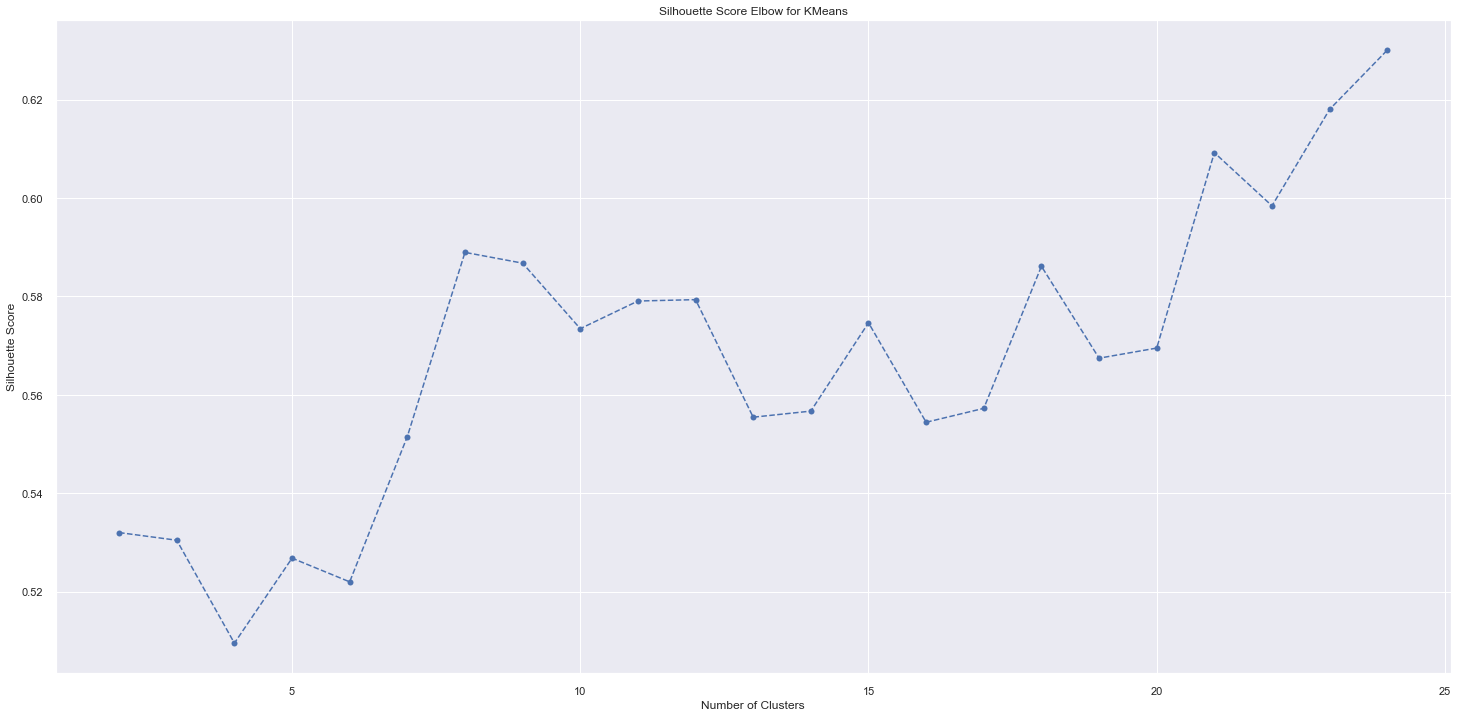

In [58]:
# Plot Silhouette Score Elbow
plt.plot(clusters, kmeans_list, linestyle='--', marker='o',color='b');
plt.title('Silhouette Score Elbow for KMeans')
plt.ylabel('Silhouette Score');
plt.xlabel('Number of Clusters');

## 7.2 GMM

In [59]:
gmm_list = []
for k in clusters:
    # Model Definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # Model Training
    gmm_model.fit(X)

    # Model Prediction
    labels = gmm_model.predict(X)

    # Model Performance
    sil_score = m.silhouette_score(X ,labels, metric='euclidean')
    gmm_list.append(sil_score)

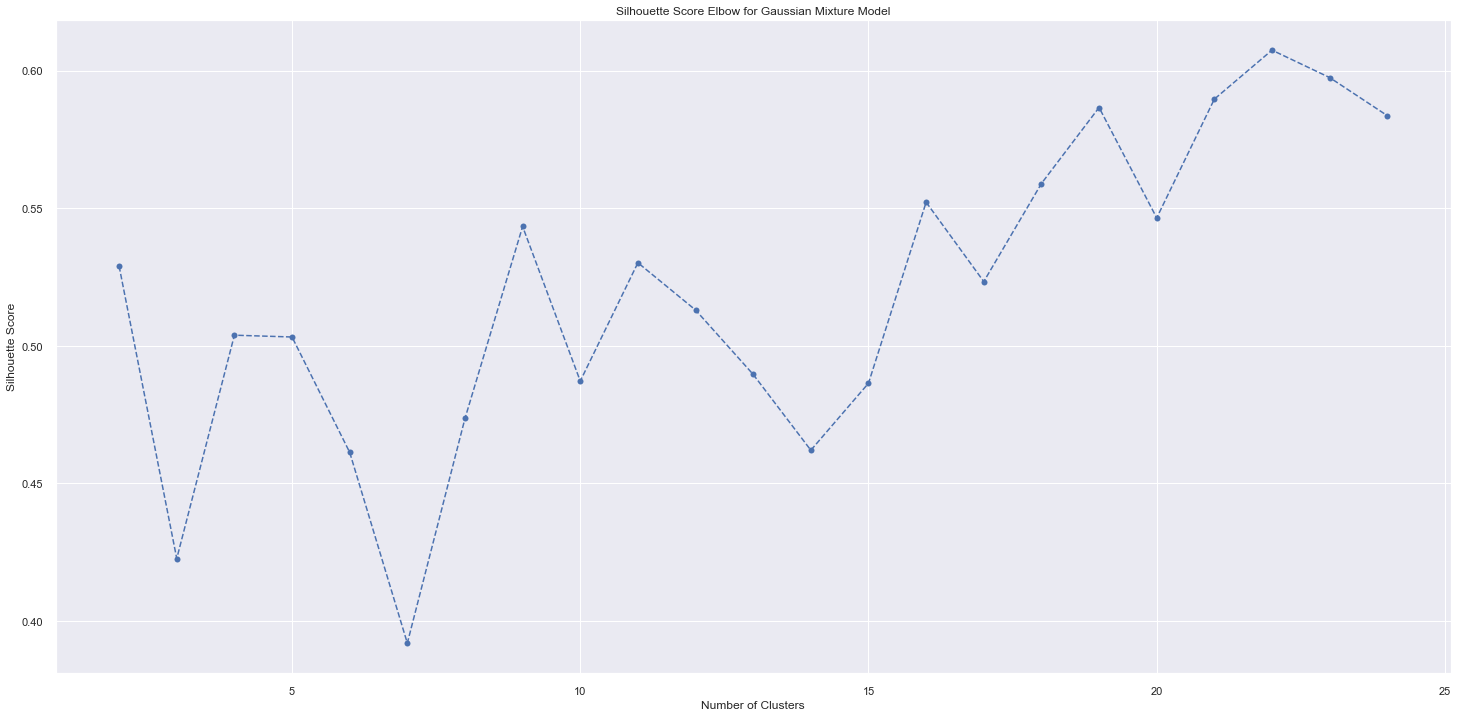

In [60]:
# Plot Silhouette Score Elbow
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.title('Silhouette Score Elbow for Gaussian Mixture Model');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');

## 7.3 Hierarchical Clustering

In [61]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

In [62]:
# Visualize dendogram I
# hc.dendrogram(
#     hc_model,
#     leaf_rotation=90,
#     leaf_font_size=8,
# )
# plt.plot()

In [63]:
# # Visualize dendrogram II
# hc.dendrogram(
#     hc_model,
#     truncate_mode='lastp',
#     p=12,
#     leaf_rotation=90,
#     leaf_font_size=8,
#     show_contracted=True,
# )
# plt.show()

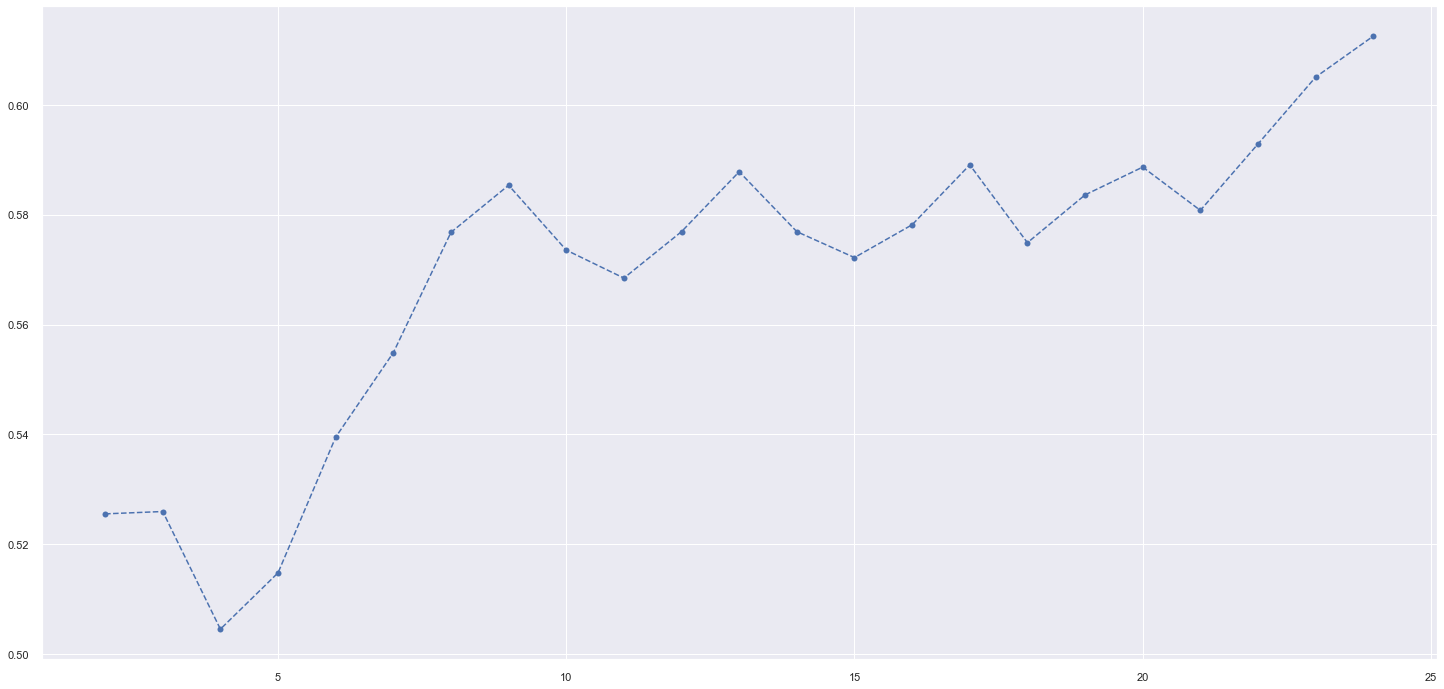

In [64]:
# Silhouette Score
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X,'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)
    
# Plot Silhouette Score
plt.plot(clusters, hc_list, linestyle='--', marker='o',color='b');

## 7.4 DBSCAN

In [65]:
min_samples = 20
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

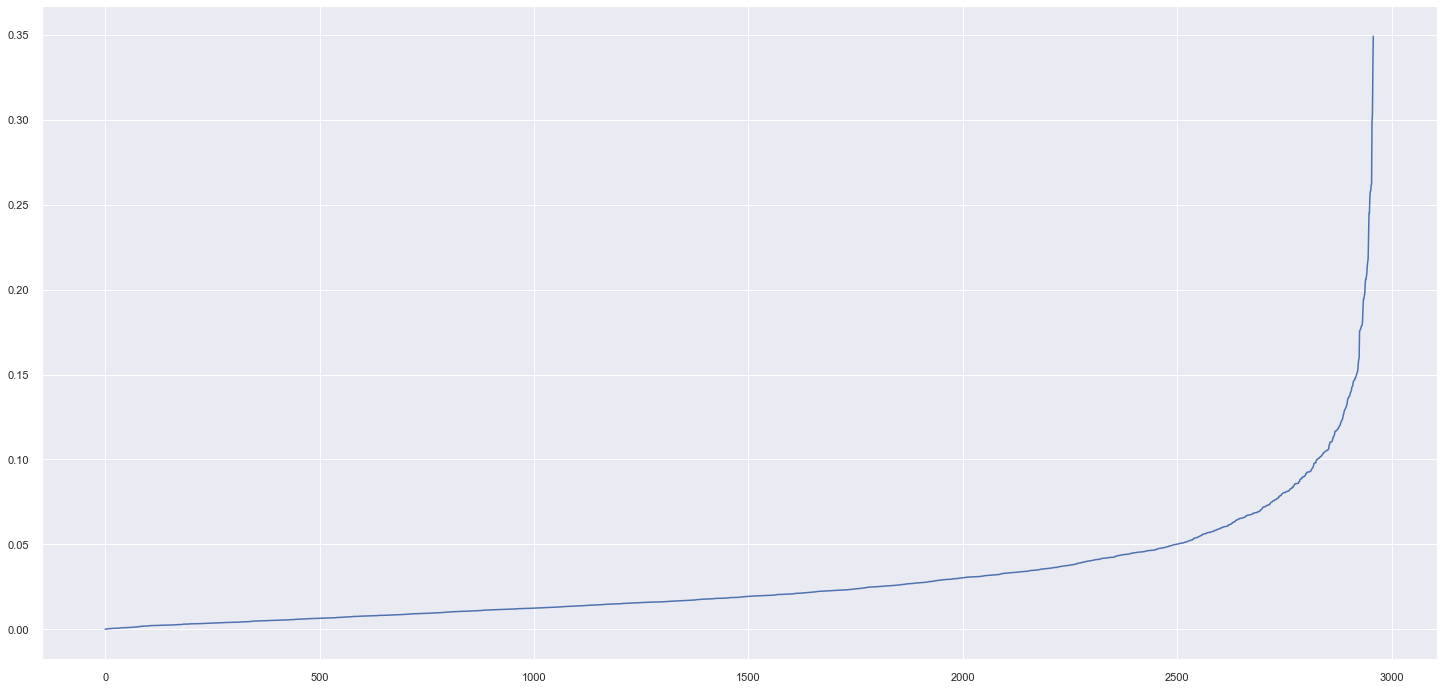

In [66]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances );

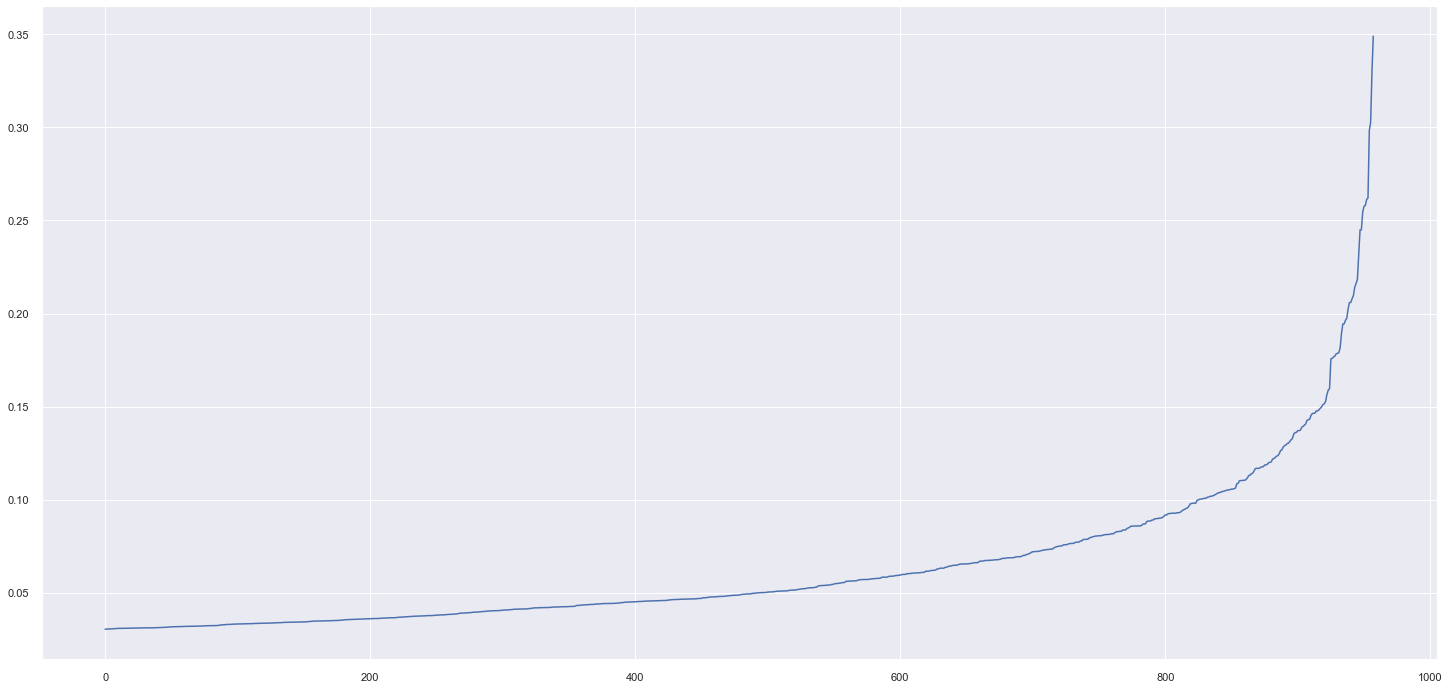

In [67]:
plt.plot( distances[2000:] );

In [68]:
eps = 0.1

# model definition 
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and prediction
labels = dbscan_model.fit_predict(X)
 
# model performance - Silhouette Score
sil = m.silhouette_score(X, labels, metric= 'euclidean')
print('Silhouette Score:',sil)
print('Number of Clusters: {}'.format(len(unique(labels))))

dbscan_list = [ sil, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

Silhouette Score: -0.53258735
Number of Clusters: 17


## 7.5 Results

In [69]:
df_results = pd.DataFrame(
                {'KMeans':kmeans_list,
                'GMM':gmm_list,
                'Hierarquical Clustering': hc_list}
                #'DBSCAN': dbscan_list}
                 ).T
df_results.columns = clusters

In [70]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.531993,0.530438,0.509513,0.526792,0.521975,0.551521,0.588959,0.586766,0.573448,0.579067,0.579351,0.555450,0.556688,0.574652,0.554421,0.557248,0.586135,0.567449,0.569505,0.609237,0.598423,0.618042,0.630076
GMM,0.528946,0.422702,0.503856,0.503203,0.461303,0.391977,0.473602,0.543344,0.487185,0.530173,0.513001,0.489597,0.462067,0.486398,0.552171,0.523336,0.558955,0.586575,0.546465,0.589618,0.607417,0.597454,0.583622
Hierarquical Clustering,0.525549,0.525978,0.504567,0.514819,0.539514,0.554890,0.576788,0.585363,0.573559,0.568466,0.576923,0.587825,0.576913,0.572200,0.578173,0.589072,0.574908,0.583607,0.588667,0.580791,0.592880,0.605049,0.612505


## 7.6 Silhouette Analysis

For k = 2, Silhouette Score: 0.5255492329597473
For k = 3, Silhouette Score: 0.5259777903556824
For k = 4, Silhouette Score: 0.5045667290687561
For k = 5, Silhouette Score: 0.5148190259933472
For k = 6, Silhouette Score: 0.5395140647888184
For k = 7, Silhouette Score: 0.5548903942108154


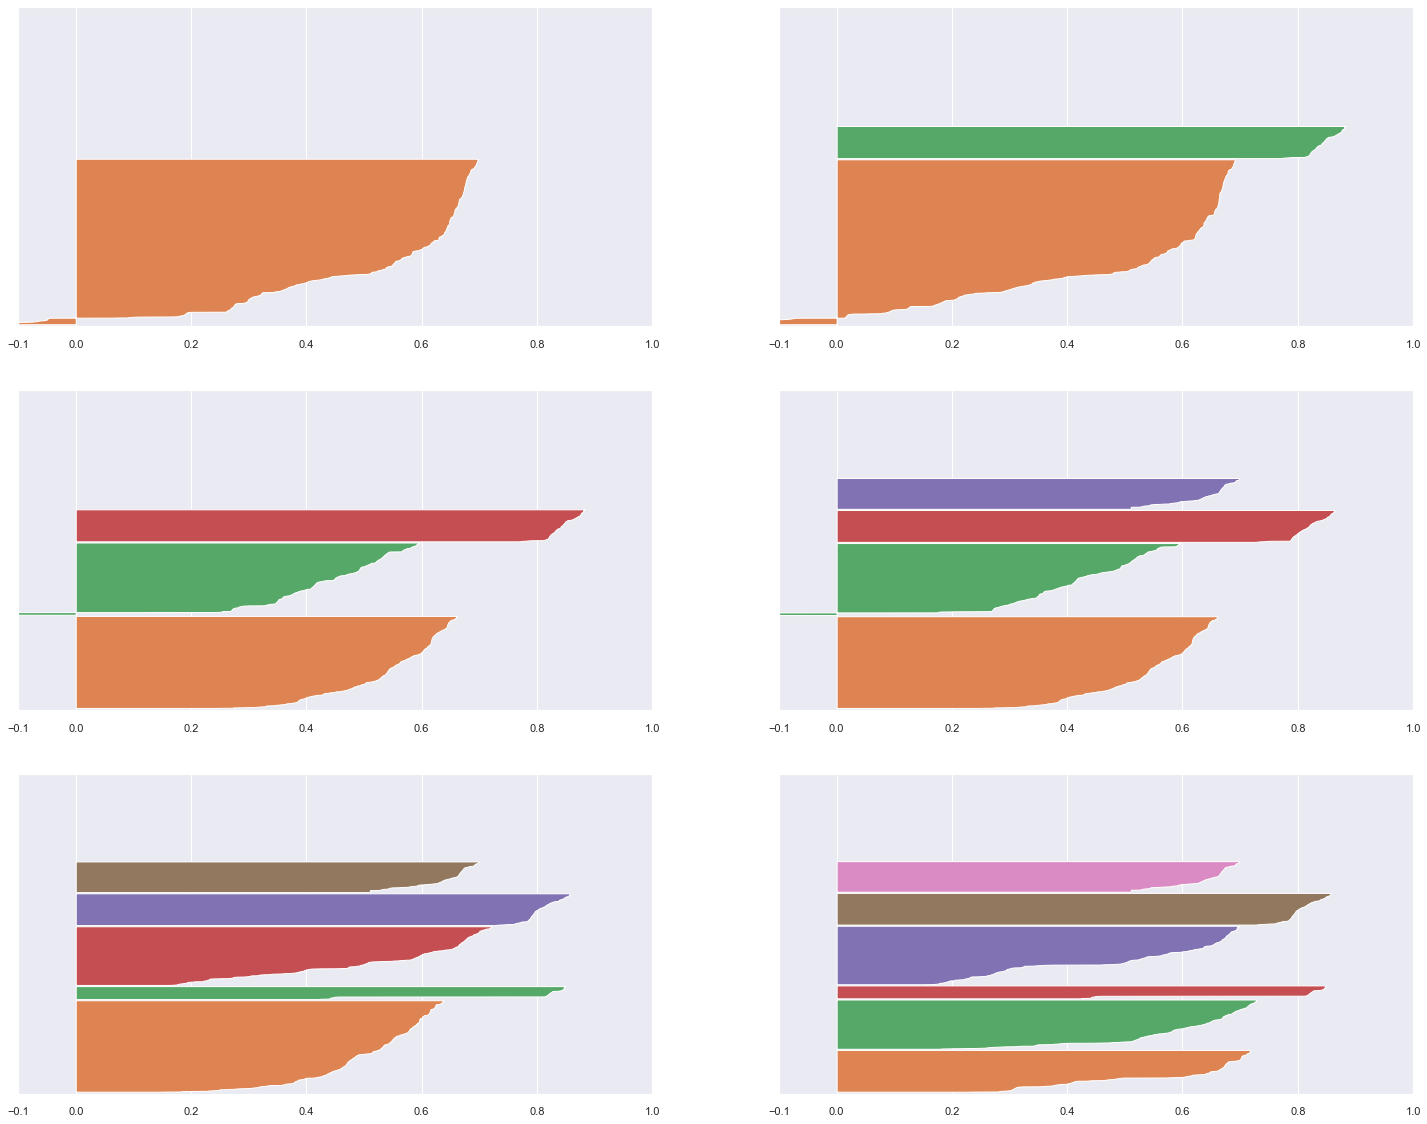

In [71]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in range(2,8):
        q, mod = divmod(k,2)
        
        ax[q-1, mod].set_xlim([-0.1,1])
        ax[q-1, mod].set_ylim([0,len(X) + (k-1)*10])
        
        # model definition and training
        hc_model = hc.linkage(X,'ward')
        
        # model prediction
        labels = hc.fcluster(hc_model, k, criterion ='maxclust')
        
        # model performance
        ss = m.silhouette_score(X, labels, metric='euclidean')
        print('For k = {}, Silhouette Score: {}'.format(k,ss ))
        
        samples_silhouette_values = m.silhouette_samples(X, labels )
        
        y_lower = 10
        
        for i in range(k):
            
            # select clusters
            ith_samples_silhouette_values = samples_silhouette_values[labels==i]
            
            # sort values
            ith_samples_silhouette_values.sort()
            
            #size clusters
            size_cluster_i = ith_samples_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap('Spectral')
            color = cmap(i/k)
            
            ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper),0,ith_samples_silhouette_values)
            
            y_lower= y_upper +10
        ax[q-1, mod].set_yticks([])
        ax[q-1, mod].set_xticks([-0.1,0,0.2, 0.4, 0.6, 0.8, 1])
        

# 8.0 Model Training

## 8.1 Final Model

In [102]:
# Model definition

# Chosen number of clusteres -> 8 
k = 8
model_train = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model Training
model_train.fit(X)

# Clustering
labels = model_train.labels_

## 8.2 Cluster Validation

In [107]:
# ## Cluster Validation
# ## WSS ( Within-cluster sum of square)
# print( 'WSS value: {}'.format( gmm_model.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.5891100168228149


# 9.0 Cluster Analysis

In [108]:
# df9 =df4.copy() 
df9 = X.copy()

# Adding the clustes 
df9['cluster'] = labels

df9.head()

,embedding_x,embedding_y,cluster
0,1.585890,3.689599,4
1,18.979393,2.241164,6
2,17.846424,2.677089,6
3,-7.455251,3.336750,3
4,0.681388,2.507767,4


## 9.1 Visualization Inspection

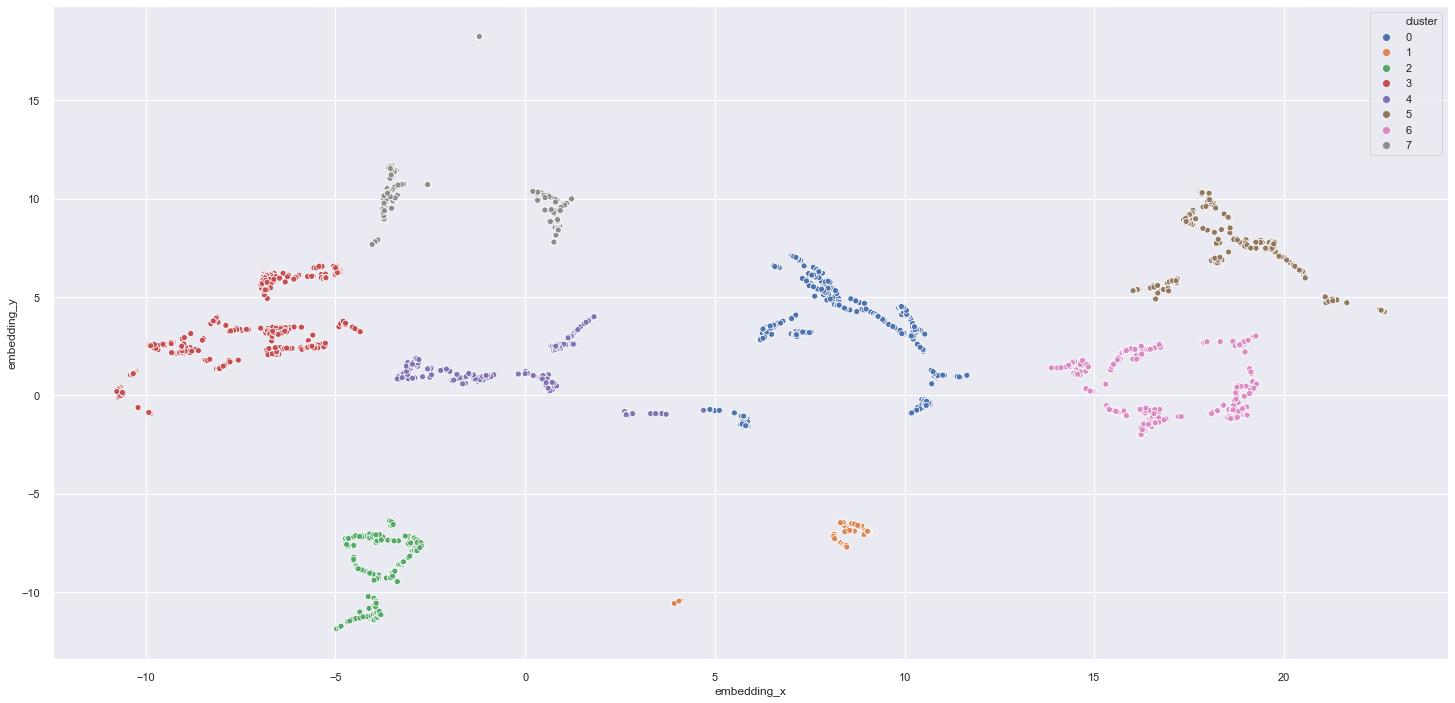

In [109]:
sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster', data=df9, palette='deep');

## 9.2 Cluster Profile

In [110]:
df9 =df4[cols_selected].copy() 

# Adding the clustes 
df9['cluster'] = labels

df9.head()

,customer_id,gross_revenue,recency_days,product_variety,frequency,returns,cluster
0,17850,5391.21,372.0,21.0,0.486111,40.0,4
1,13047,3232.59,56.0,105.0,0.048780,35.0,6
2,12583,6705.38,2.0,114.0,0.045699,50.0,6
3,13748,948.25,95.0,24.0,0.017921,0.0,3
4,15100,876.00,333.0,1.0,0.136364,22.0,4


In [124]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')


# Average Product Variety
df_avg_pv = df9[['product_variety','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_pv, how='inner',on='cluster')

# Average frequency
df_freq = df9[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_freq, how='inner',on='cluster')

# Average Returns
df_cg = df9[['returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_cg, how='inner',on='cluster')

# Assign cluster Insiders number
insiders = df_cluster.sort_values(by='gross_revenue', ascending=False).cluster.to_list()[0]

# Clusters sorted by gross revenue
df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,product_variety,frequency,returns
5,5,395,13.353617,8818.857924,22.475949,245.582278,0.057107,159.546835
1,1,123,4.158215,5481.036179,4.333333,88.666667,0.067993,18.203252
6,6,466,15.753888,2857.403197,41.137339,114.613734,0.041834,22.912017
0,0,515,17.410412,1999.271961,73.034951,66.687379,0.047084,35.355340
4,4,324,10.953347,1420.705432,69.851852,42.194444,0.055069,10.580247
2,2,300,10.141988,1350.101533,9.116667,27.703333,0.050337,1.713333
3,3,537,18.154158,863.258268,61.677840,22.014898,0.055831,1.424581
7,7,298,10.074375,466.477785,219.255034,19.674497,0.157929,2.389262


**Cluster Names:**
* 5 Cluster Insiders
* 1 Cluster More Products
* 6 Cluster Spend Money 
* 0 Cluster Even More Products
* 4 Cluster Less Days
* 2 Cluster Less 1k
* 3 Cluster Stop Returners
* 7 Cluster More Purchases

# 10.0 Exploratory Data Analysis - Cluster Profiles

In [85]:
df10 = df9.copy()
df10.head()

,customer_id,gross_revenue,recency_days,product_variety,frequency,returns,cluster
0,17850,5391.21,372.0,21.0,0.486111,40.0,4
1,13047,3232.59,56.0,105.0,0.048780,35.0,6
2,12583,6705.38,2.0,114.0,0.045699,50.0,6
3,13748,948.25,95.0,24.0,0.017921,0.0,3
4,15100,876.00,333.0,1.0,0.136364,22.0,4


## 10.1 MindMap - Hypothesis BrainStorm

1. Femômeno
2. Entidades (Customer, location, finance, family, etc.)
3. Característica da Entidade (Customer --> Nome, Idade, salário, escolaridade, etc.)

## 10.2 Business Hypothesis

1. Afirmação 
2. Comparação entre variáveis
3. Valor base de comparação

 Hipóteses Compra
 
1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**
7. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do gmv pelos clientes insiders.**

## 10.3 Hypothesis Selection

**H1**: Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras

**Verdade**: O cluster insider possuem um volume de compra de produtos de 41% do total de compras.

In [126]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == insiders, 'product_variety'].sum()
df_sales_total = df10.loc[:, 'product_variety'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 41.22%


**H2**. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras

**Verdadeiro**: O cluster insider possuem um volume de GMV de 44% do total de compras.

In [127]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == insiders, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 43.62%


**H3**. Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes

**Falso**: O cluser insiders tem a média de devoluções acima da média geral

In [128]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == insiders, 'returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 160.0 vs Avg Return All:34.0


**H4**. A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a  mediana do faturamento geral.

**Verdadeiro**. A mediana do faturamento é 254% acima da média.

In [129]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == insiders, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 254.44%


**H5**. A GMV dos clientes insiders está concentrada no 3 quartil.

**Falso**. O faturamento do cluster insiders está concentrada na quartil 1

In [130]:
np.percentile( df10.loc[df10['cluster'] == insiders, 'gross_revenue'], q=0.1 )

518.3250999999997

## 10.4 Business Questions

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [131]:
df10.loc[df10['cluster'] == insiders, 'customer_id'].head()

12    16029
14    12431
15    17511
19    13408
24    15513
Name: customer_id, dtype: int32

2. Quantos clientes farão parte do grupo?

In [132]:
print('O total de {} clientes farão parte do grupo Insiders.'.format(df10.loc[df10['cluster'] == insiders, 'customer_id'].size))

O total de 395 clientes farão parte do grupo Insiders.


3. Quais as principais características desses clientes ?

 Cluster Insider
- Número de customers: 395 (13% do customers )
- Faturamento médio: $8818.85 dólares
- Recência média: 22 dias
- Média de Produtos comprados: 245 produtos
- Frequência de Produtos comprados: 0.05 produtos/dia


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [133]:
print('Os Insiders contribuem com {:.1%} do faturamento da empresa.'.format(df10.loc[df10.cluster==insiders]['gross_revenue'].sum().round(2) / df10.gross_revenue.sum()))

Os Insiders contribuem com 43.6% do faturamento da empresa.


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

A clusterização realizada nesse projeto abstrai a noção de tempo dentro dos clusters, ao agregar os dados em  médias. Essa pergunta exigiria que se calculasse o faturamento do Insiders de mês em mês para, assim, possuir uma série temporal que servisse para realizar uma predição de faturamento.

6. Quais as condições para uma pessoa ser elegível ao e removida do Insiders ?

Essas condições são determinadas pelo modelo tanto para eleição quanto para remoção. O procedimento que será feito periodicamente é: a cada rodagem do modelo, o cliente será marcado com o respectivo cluster e a data em que foi feita a clusterização; na rodagem seguinte, adiciona-se mais duas colunas com o novo cluster (o mesmo do anterior ou não) e a nova data e assim sucessivamente. 
 

7. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    * Descontos para o cluster More Products
    * Sistema de recomendação para o cluster Even More Products
    * Cross-sell para o cluster More Products
    * Distribuição de cupons para o cluster Spend Money

# 11.0 Deploy